<a href="https://colab.research.google.com/github/dangduong2806/google-colab/blob/main/transformer_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving colors1.csv to colors1.csv


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd

In [3]:
df = pd.read_csv("colors1.csv")
df.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


Standardize data

In [4]:
df["red"] = df["red"] / 255
df["green"] = df["green"] / 255
df["blue"] = df["blue"] / 255
df.head()

,name,red,green,blue
0,parakeet,0.682353,0.713725,0.341176
1,saddle brown,0.345098,0.203922,0.003922
2,cucumber crush,0.870588,0.929412,0.843137
3,pool blue,0.525490,0.760784,0.788235
4,distance,0.384314,0.431373,0.509804


In [5]:
len(df["name"])

14357

Tách input và output

In [6]:
X_texts = df['name'].astype(str).values
y_rgb = df[['red', 'green', 'blue']].values

Chuyển đổi tên màu thành chuỗi số

In [7]:
vectorizer = layers.TextVectorization(output_sequence_length=5)
vectorizer.adapt(X_texts)
vocab_size = len(vectorizer.get_vocabulary())

Sử dụng mô hình Transfromer Encoder để update data

In [8]:
def transformer_encoder(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = layers.Input(shape=(None, embed_dim))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention = layers.Dropout(rate)(attention)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ffn = layers.Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.L2(1e-3))(out1)
    ffn = layers.Dense(embed_dim, kernel_regularizer=regularizers.L2(1e-3))(ffn)
    ffn = layers.Dropout(rate)(ffn)
    outputs = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return models.Model(inputs, outputs)

In [9]:
input_text = layers.Input(shape=(), dtype="string")
x = vectorizer(input_text)
x = layers.Embedding(input_dim=vocab_size, output_dim=64)(x)
x = layers.Dropout(0.2)(x)
x = transformer_encoder(embed_dim=64, num_heads=2, ff_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3, activation='sigmoid')(x)

In [10]:
model = models.Model(input_text, output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [11]:
len(X_texts)

14357

Huấn luyện

In [12]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model_transformer_encoder.weights.h5',  # Must end with .weights.h5
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Khởi tạo callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # theo dõi val_loss (có thể là 'val_accuracy' tùy bài toán)
    factor=0.5,              # mỗi lần giảm thì LR = LR * factor
    patience=5,              # nếu sau 5 epoch val_loss không cải thiện thì giảm LR
    min_lr=1e-6,             # learning rate nhỏ nhất có thể giảm tới
    verbose=1                # in log khi learning rate thay đổi
)

In [15]:
history = model.fit(
    X_texts,
    y_rgb,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    callbacks= [checkpoint, reduce_lr, earlystop]
)


Epoch 1/300
357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2289 - mae: 0.2172
Epoch 1: val_loss improved from inf to 0.18033, saving model to best_model_transformer_encoder.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2288 - mae: 0.2171 - val_loss: 0.1803 - val_mae: 0.1885 - learning_rate: 1.0000e-04
Epoch 2/300
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1695 - mae: 0.1828
Epoch 2: val_loss improved from 0.18033 to 0.14100, saving model to best_model_transformer_encoder.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1694 - mae: 0.1828 - val_loss: 0.1410 - val_mae: 0.1720 - learning_rate: 1.0000e-04
Epoch 3/300
354/359 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1289 - mae: 0.1597
Epoch 3: val_loss improved from 0.14100 to 0.11285, saving model to best_model_transformer_encoder.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1288 - mae: 0.1596 - val_loss: 0.1129 - val_mae: 0.1645 - learning_rate: 1.0000e-04
Epoch 4/300
355/3

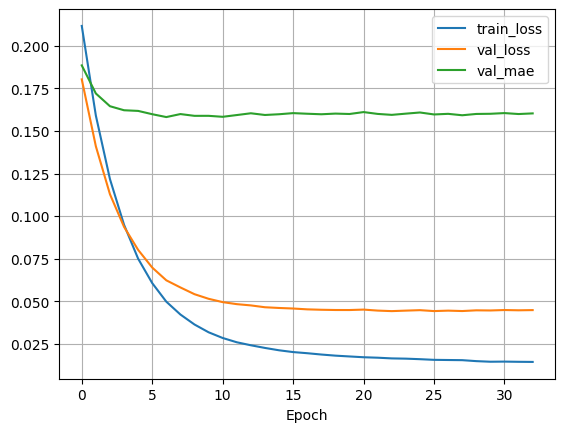

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import matplotlib.pyplot as plt

In [43]:
def scale(n):
    return n * 255.0

In [19]:
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2, 2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [44]:
def predict(name):
    name = name.lower()
    tokens = vectorizer([name])
    tokens = tf.strings.as_string(tokens)
    tokens = tf.reshape(tokens, [-1])

    # Dự đoán RGB
    pred = model.predict(tokens)[0]  # Lấy mảng đầu tiên nếu batch_size = 1
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r, g, b)
    plot_rgb(pred)

lemon yellow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
lemon yellow, R,G,B: 167.59332 142.44258 118.88749


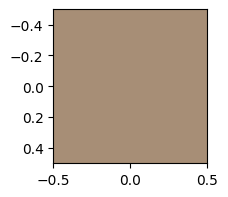

In [45]:
n = input()
predict(n)

Sky Blue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
sky blue, R,G,B: 167 142 118


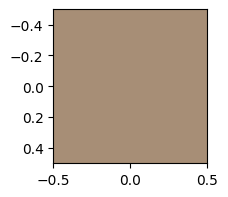

In [24]:
n = input()
predict(n)

Cucumber
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
cucumber, R,G,B: 167 142 118


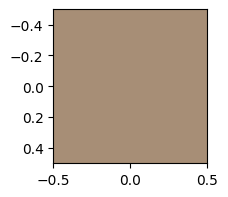

In [25]:
n = input()
predict(n)

Ocean
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
ocean, R,G,B: 167 142 118


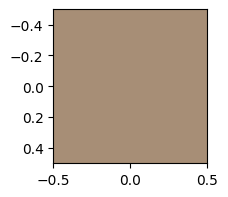

In [26]:
n = input()
predict(n)

In [27]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb,test_size=0.3,
    shuffle=True,
    random_state=42
)

In [30]:
y_pred = model.predict(X_val)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [31]:
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=33fb90e1b57cdd05f22e7405402d95f455083bdc8dcddb50d06032a954fb811e
  Stored in directory: /root/.cache/pip/wheels/f5/ce/f7/7039d7b57e1a27fc2f6bb2b2abed1be362eefece03caf2fb9a
Successfully built colormath


In [33]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import numpy as np
if not hasattr(np, 'asscalar'):
    np.asscalar = lambda x: x.item()

def compute_ciede2000_each_point(y_true, y_pred):
    delta_e_list = []
    for true_rgb, pred_rgb in zip(y_true, y_pred):
        c1 = sRGBColor(*true_rgb, is_upscaled=True)
        c2 = sRGBColor(*pred_rgb, is_upscaled=True)
        lab1 = convert_color(c1, LabColor)
        lab2 = convert_color(c2, LabColor)
        delta_e = float(delta_e_cie2000(lab1, lab2))
        delta_e_list.append(delta_e)
    return delta_e_list

# Scale về [0, 255] nếu cần
y_true_scaled = np.clip(y_val * 255, 0, 255)
y_pred_scaled = np.clip(y_pred * 255, 0, 255)

delta_e_list = compute_ciede2000_each_point(y_true_scaled, y_pred_scaled)

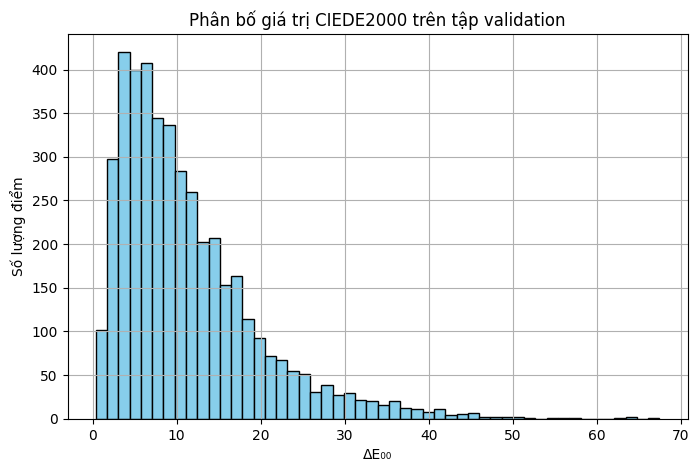

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(delta_e_list, bins=50, color='skyblue', edgecolor='black')
plt.title("Phân bố giá trị CIEDE2000 trên tập validation")
plt.xlabel("ΔE₀₀")
plt.ylabel("Số lượng điểm")
plt.grid(True)
plt.show()

In [36]:
results = model.evaluate(X_val, y_val)

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0207 - mae: 0.0987
